In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 

In [2]:
datos_diabetes = pd.read_csv('/home/juan/machineLearning2025/datasets/diabetes_012_health_indicators_BRFSS2015.csv')
#Crear la columna diabetes_01 que unifique prediabetes con diabetes
datos_diabetes['diabetes_01'] = datos_diabetes['Diabetes_012']
datos_diabetes['diabetes_01'] = datos_diabetes['diabetes_01'].replace(2,1)

#Reparar nombres de columnas. Se usa el formato loweCamelCase para el nombre de las caracteristicas.

new_col_names = []

for name in datos_diabetes.columns:
    # Luego, pon todas las letras en minúsculas
    name_lowered_first_letter = name[0].lower() + name[1:]
    # Elimina los espacios al principio y al final
    name_stripped = name_lowered_first_letter.strip()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_stripped.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_names.append(name_no_spaces)

datos_diabetes.columns = new_col_names

datos_diabetes = datos_diabetes.rename(columns={'bMI':'bmi'})

datos_diabetes.columns

datos_diabetes.drop(columns=['physHlth', 'mentHlth'], inplace=True)

datos_diabetes = datos_diabetes[datos_diabetes['bmi'] <= 50] #FILTRADO DE BMI

In [3]:
#Funciones run_model() y evaluate_model()


def run_model(X_train, X_test, Y_train, Y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, Y_train)
    return clf_base
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']

In [4]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter  
from imblearn.over_sampling import RandomOverSampler


X = datos_diabetes.drop(["diabetes_01", "diabetes_012"], axis=1)
y = datos_diabetes["diabetes_01"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#Balanceamos con RandomOverSampler
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
 
print ("before resampling {}".format(Counter(y_train)))
print ("after resampling {}".format(Counter(y_train_res)))

before resampling Counter({0.0: 159361, 1.0: 29267})
after resampling Counter({0.0: 159361, 1.0: 159361})


In [5]:
# SciKit Learn MLP
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20,20)],
    'alpha': np.logspace(-3, 3, 7), ##penalizacion de los pesos
    'learning_rate_init': [0.001, 0.01, 0.1], #paso de aprendizaje
}

grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 1000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train_res, y = y_train_res)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
27,0.010,"(20, 20, 20)",100.000,0.760547,0.000795,0.760829,0.000941
47,0.001,"(20, 20, 20)",100.000,0.760420,0.001066,0.760768,0.000727
31,0.001,"(10, 10)",100.000,0.760158,0.000723,0.760323,0.000973
23,0.100,"(20, 20, 20)",100.000,0.760073,0.000899,0.760324,0.000263
26,0.001,"(20, 20, 20)",0.001,0.759971,0.000852,0.760006,0.000471
4,0.010,"(20, 20, 20)",10.000,0.759365,0.000764,0.759896,0.000619
39,0.010,"(20, 20, 20)",0.010,0.759183,0.000748,0.759185,0.001011
10,0.100,"(20, 20, 20)",0.100,0.758940,0.001251,0.759083,0.001291
0,0.001,"(20, 20, 20)",0.100,0.758939,0.001082,0.759492,0.000435
2,0.001,"(20, 20, 20)",0.010,0.758913,0.000446,0.759073,0.000715


In [7]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
27,0.010,"(20, 20, 20)",100.000,0.760547,0.000795,0.760829,0.000941
47,0.001,"(20, 20, 20)",100.000,0.760420,0.001066,0.760768,0.000727
31,0.001,"(10, 10)",100.000,0.760158,0.000723,0.760323,0.000973
23,0.100,"(20, 20, 20)",100.000,0.760073,0.000899,0.760324,0.000263
26,0.001,"(20, 20, 20)",0.001,0.759971,0.000852,0.760006,0.000471
4,0.010,"(20, 20, 20)",10.000,0.759365,0.000764,0.759896,0.000619
39,0.010,"(20, 20, 20)",0.010,0.759183,0.000748,0.759185,0.001011
10,0.100,"(20, 20, 20)",0.100,0.758940,0.001251,0.759083,0.001291
0,0.001,"(20, 20, 20)",0.100,0.758939,0.001082,0.759492,0.000435
2,0.001,"(20, 20, 20)",0.010,0.758913,0.000446,0.759073,0.000715


           train  test
Exactitud   0.75  0.72
F1          0.76  0.47
APS         0.80  0.45
ROC AUC     0.83  0.82


(0.7592692084892834, 0.46896181063569314)

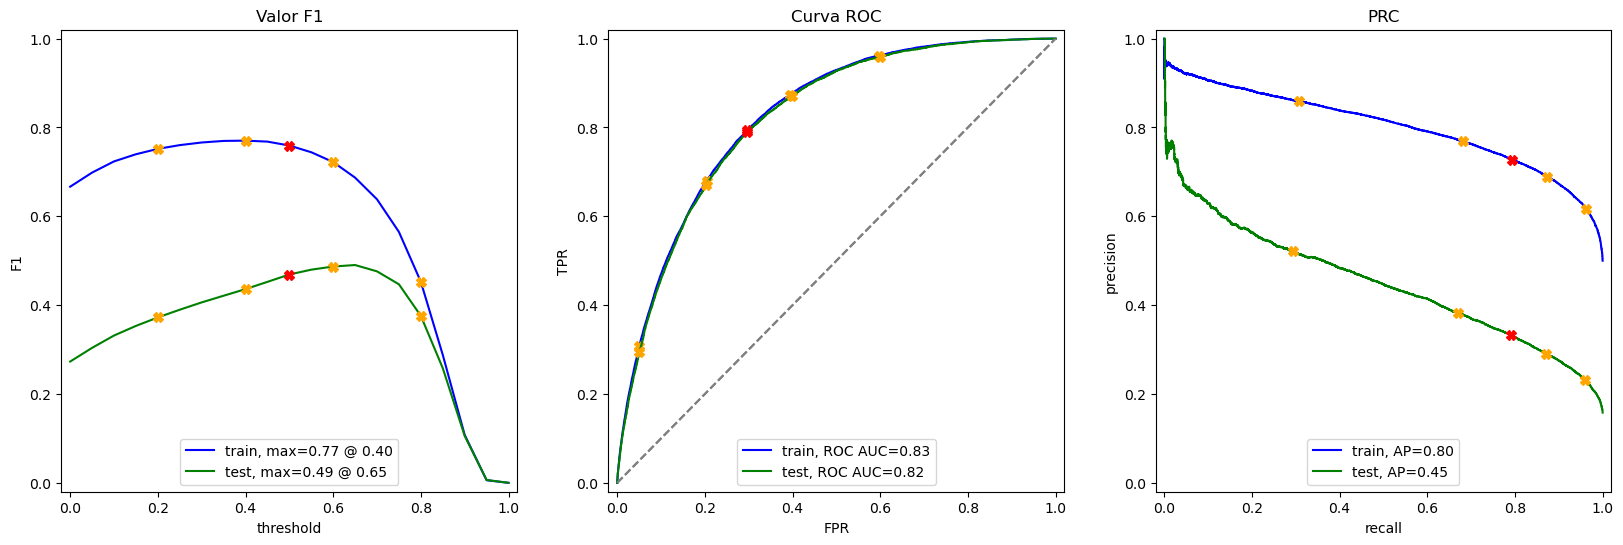

In [8]:
evaluate_model(grid.best_estimator_, X_train_res, y_train_res, X_test, y_test)

In [5]:
# SciKit Learn MLP para las mejores 3 caracteristicas
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20,20)],
    'alpha': np.logspace(-3, 3, 7), ##penalizacion de los pesos
    'learning_rate_init': [0.001, 0.01, 0.1], #paso de aprendizaje
}

grid_best3 = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 1000),
        param_distributions = param_distributions,
        n_iter     = 50, # Número máximo de combinaciones probadas
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

X_best3_train_res = X_train_res[['bmi', 'income', 'age']]
grid_best3.fit(X = X_best3_train_res, y = y_train_res)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid_best3.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
31,0.001,"(10, 10)",100.000,0.710922,0.000336,0.710779,0.001329
23,0.100,"(20, 20, 20)",100.000,0.710330,0.000961,0.710372,0.001193
32,0.010,"(20, 20, 20)",0.001,0.710322,0.000416,0.709992,0.000834
9,0.010,"(10, 10)",0.010,0.710130,0.001598,0.710245,0.001194
27,0.010,"(20, 20, 20)",100.000,0.709895,0.000879,0.710018,0.000928
0,0.001,"(20, 20, 20)",0.100,0.709888,0.001041,0.709991,0.001209
34,0.100,"(10, 10)",10.000,0.709816,0.001461,0.709736,0.001729
26,0.001,"(20, 20, 20)",0.001,0.709788,0.001371,0.709661,0.001156
45,0.100,"(10, 10)",100.000,0.709711,0.000359,0.709798,0.001117
47,0.001,"(20, 20, 20)",100.000,0.709674,0.000871,0.709815,0.000779


           train  test
Exactitud   0.70  0.66
F1          0.71  0.41
APS         0.74  0.36
ROC AUC     0.77  0.76


(0.7109214003533579, 0.4106998859939382)

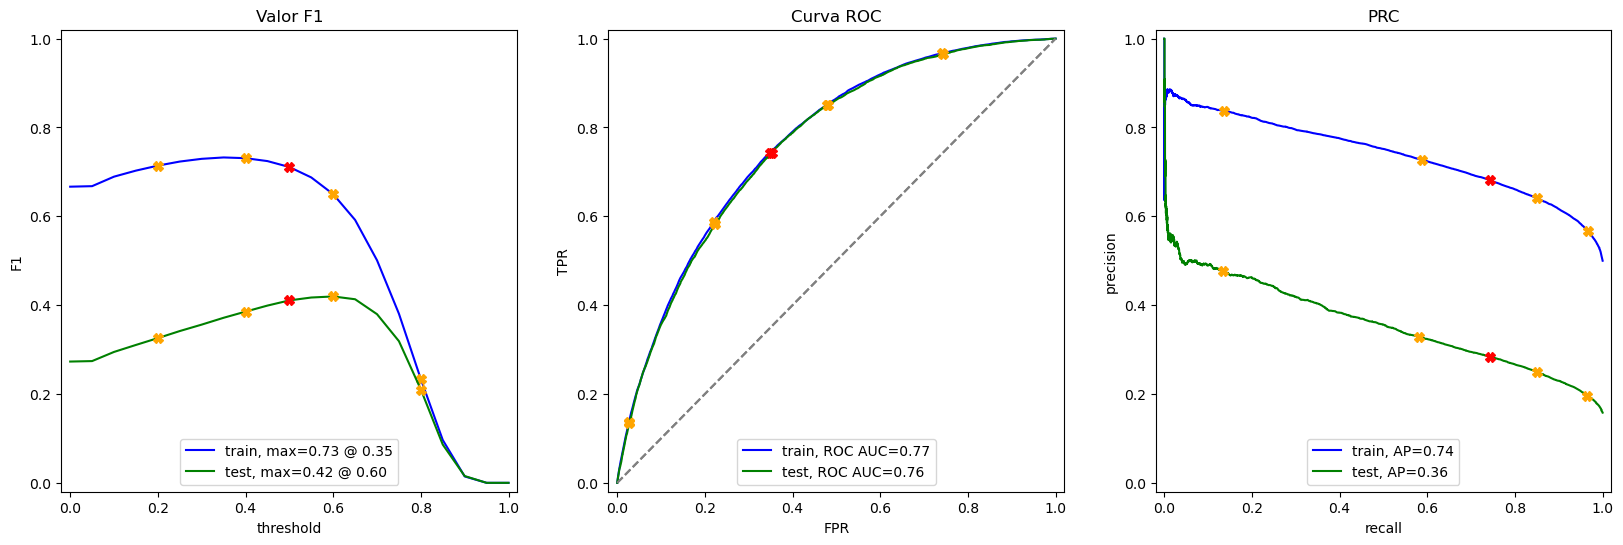

In [8]:
X_best3_test = X_test[['bmi', 'income', 'age']]
evaluate_model(grid_best3.best_estimator_, X_best3_train_res, y_train_res, X_best3_test, y_test)

In [ ]:
###ENtrenamiento de la red despues de balancear con SMOTE
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#SMOTE resampleo de la clase minoritaria sin duplicados
from imblearn.over_sampling import SMOTE
os_us = SMOTE()
X_train_res_smote, y_train_res_smote = os_us.fit_resample(X_train, y_train)
 

In [8]:
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
mlp_smote = MLPClassifier(hidden_layer_sizes=(20,20,20), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=1000)
mlp_smote.fit(X_train_res_smote,y_train_res_smote)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)